# Semantic segmentation using Line Search

In this example, we are going to implement an idea similar to "Bounding Box Tightness Prior for Weakly Supervised Image Segmentation" proposed [here](https://arxiv.org/abs/2110.00934) in Tensorflow.

The core idea of the paper is to perform semantic segmentation while using only bounding box as a ground truth. The paper uses multiple instance learning(MIL) to create positive and negative bags of samples using the bounding box. In MIL, a bag is labeled as negative if all of its samples are negative and a bag is positive if it has at least one sample which is positive. For semantic segmenation using bounding box, authors propose that we consider the lines passing through bounding box as positive bags and all other lines as negative. As shown in the following image, the green and yellow lines are considered to be positive and blue lines are considered to be negative for a particular category.

<p align="center">
<img src="https://github.com/fastestimator-util/fastestimator-misc/blob/master/resource/pictures/apphub/line_search/example.PNG?raw=true" width=800 height=400>
</p>

Here we are implementing a simplified approach inspired by the Paper. Instead of selecting these positive and negative lines from the image prediction, we perform a max operation over all the axes individually which results in a 1D vector per axis called prediction vectors. Similar to the parent paper we assume that we have accurate bounding box information for each object in the image. We convert these bounding box co-ordinates into binary masks for each object. Once we have these binary masks, we again perform a max operation over all the axes individually which results in a 1D vector per axis called bounding-box vectors. These bounding-box vectors per object acts as our ground truth for an object. Once we have prepared the prediction vectors and the bounding-box vector for each object, we can use Binary Cross-Entropy as a loss function.


### Importing Libraries

In [1]:
import tempfile

import cv2
import numpy as np
import tensorflow as tf
from skimage import measure

import fastestimator as fe
from fastestimator.architecture.tensorflow import UNet
from fastestimator.dataset.data import montgomery
from fastestimator.op.numpyop import Delete
from fastestimator.op.numpyop import LambdaOp as NLambdaOp
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import Resize, Rotate
from fastestimator.op.numpyop.univariate import Minmax, ReadImage, Binarize
from fastestimator.op.tensorop import LambdaOp
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Dice

from fastestimator.util import BatchDisplay, GridDisplay

In [2]:
# training_parameters
epochs=20
batch_size=8
train_steps_per_epoch = 500
eval_steps_per_epoch = None
save_dir=tempfile.mkdtemp()
data_dir=None
im_size = 512
line_degree = 45


## Step1: Dataset and Pipeline Preparation

In this step, we will load Montogomery dataset and prepare FastEstimator's data Pipeline.


### Load Dataset

Let's use a FastEstimator API to load the Montogomery data and create a CSVDataset.


In [3]:
csv_dataset = montgomery.load_data(root_dir=data_dir)

### Customized Ops

Since our aim is to use bounding boxes to predict the pixel wise segmentation mask, let us generate a 2D binary mask consisting only the bounding box of the lungs using the pixel wise ground truth available

In [4]:
class BoundingBoxMask(fe.op.numpyop.NumpyOp):
    """Converting Pixel Level Binary Mask to a Bounding Box binary mask.
    
    Bounding box coordinates are calculated using the Pixel level binary mask. These coordinates are then used to
    create a Binary mask of Bounding Boxes.
    Args:
        inputs: Key(s) of  masks to be combined.
        outputs: Key(s) into which to write the combined masks.
        mode: What mode(s) to execute this Op in. For example, "train", "eval", "test", or "infer".
    """
    def forward(self, data, state):
        y_true = data
        mask = np.zeros_like(y_true)

        blobs, n_blob = measure.label(y_true[:, :, 0], background=0, return_num=True)
        for b in range(1, n_blob + 1):
            blob_mask = blobs == b
            coords = np.argwhere(blob_mask)
            x1, y1 = coords.min(axis=0)
            x2, y2 = coords.max(axis=0)
            box = [y1, x1, y2, x2]
            mask[box[1]:box[3] + 1, box[0]:box[2] + 1, 0] = 1

        return mask

### Set up the preprocessing Pipline

In this example, the data preprocessing steps include Merging masks into one dimension, expanding image dimension, rotating the image and mask at a random angle, normalizing the image pixel values to the range [0, 1], and binarizing pixel values. We set up these processing steps using Ops, while also defining the data source and batch size for the Pipeline.

NOTE : To generate Bounding Box mask, it is necessary for input mask to be Binarized. Therefore, we make sure to binarize the pixel-wise mask before building bounding-box based mask.

Here, we use rotation as a preprocessing step to extract positive bags at a random angle in the later steps. Also, the BoundingBoxFromMask Op is used to extract bounding box based binary masks from the actual ground truth.

In [5]:
pipeline = fe.Pipeline(
    train_data=csv_dataset,
    eval_data=csv_dataset.split(0.2),
    batch_size=batch_size,
    ops=[
        ReadImage(inputs="image", parent_path=csv_dataset.parent_path, outputs="image", color_flag='gray'),
        ReadImage(inputs="mask_left", parent_path=csv_dataset.parent_path, outputs="mask_left", color_flag='gray'),
        ReadImage(inputs="mask_right", parent_path=csv_dataset.parent_path, outputs="mask_right", color_flag='gray'),
        NLambdaOp(fn=lambda x, y: np.maximum(x, y), inputs=("mask_left", "mask_right"), outputs="mask"),
        Resize(image_in="image", width=im_size, height=im_size),
        Resize(image_in="mask", width=im_size, height=im_size),
        Sometimes(numpy_op=Rotate(image_in="image",
                                  mask_in="mask",
                                  limit=(-line_degree, line_degree),
                                  border_mode=cv2.BORDER_CONSTANT,
                                  mode='train')),
        Minmax(inputs="image", outputs="image"),
        Minmax(inputs="mask", outputs="mask"),
        Binarize(inputs="mask", outputs="mask", threshold=0.5),
        BoundingBoxMask(inputs="mask", outputs="box_mask"),
        Delete(keys=("mask_left", "mask_right"))
    ])



### Validate Pipeline

In order to make sure the pipeline works as expected, we need to visualize its output. Pipeline.get_results will return a batch of data for this purpose:


In [6]:
data = pipeline.get_results()
image = data["image"]
mask = data["mask"]
bbox_mask = data['box_mask']
print("the pipeline input image size: {}".format(image.numpy().shape))
print("the pipeline input mask size: {}".format(mask.numpy().shape))
print("the pipeline output bounding box mask size: {}".format(bbox_mask.numpy().shape))

the pipeline input image size: (8, 512, 512, 1)
the pipeline input mask size: (8, 512, 512, 1)
the pipeline output bounding box mask size: (8, 512, 512, 1)


Let's select 4 samples and visualize the differences between the Pipeline input and output.

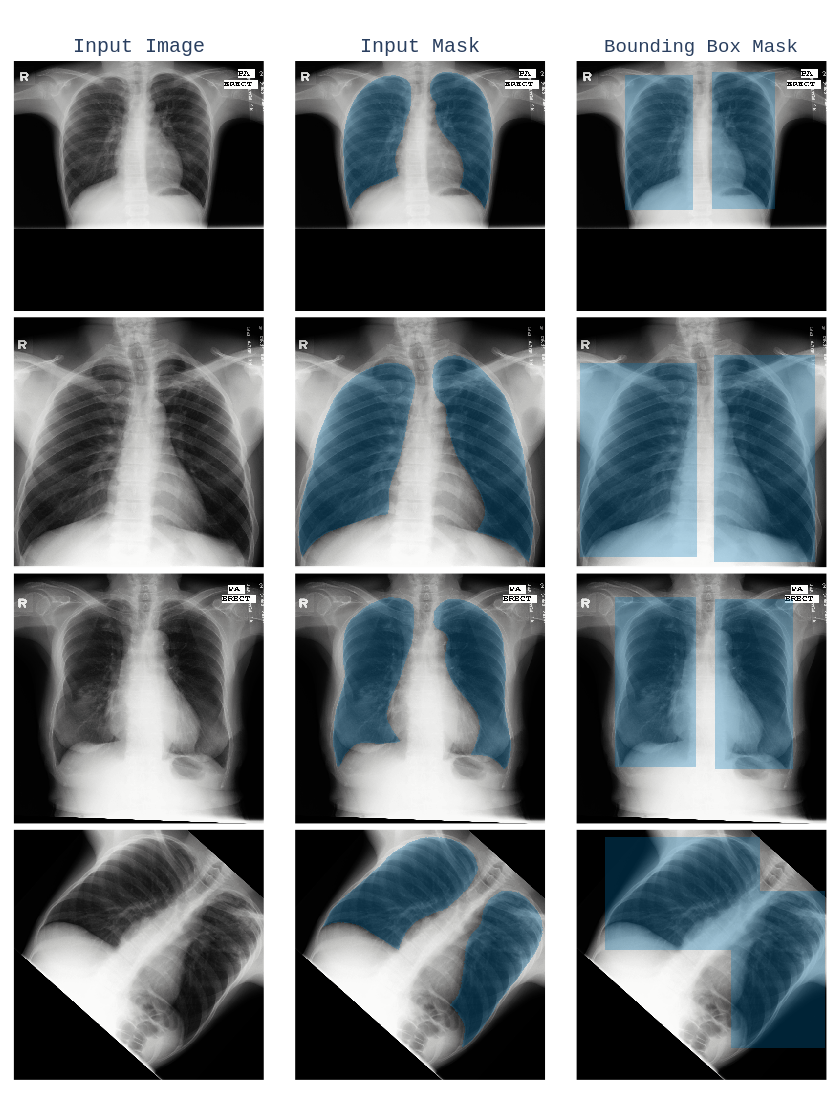

In [7]:
sample_num = 4

GridDisplay([BatchDisplay(image=image[0:sample_num], title="Input Image"), 
             BatchDisplay(image=image[0:sample_num], masks=mask[0:sample_num], title="Input Mask"),
            BatchDisplay(image=image[0:sample_num], masks=bbox_mask[0:sample_num], title="Bounding Box Mask")]).show()

## Step 2 - Network construction

### Model Construction

Here we use Tensorflow based UNet implementation with adam optimizer

In [8]:
model = fe.build(model_fn=lambda: UNet(input_size=(im_size, im_size, 1)),
                 optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.0001))


2023-01-04 22:56:54.253869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 22:56:54.720739: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38418 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:bd:00.0, compute capability: 8.0


### Network Definition

Now since we have our pipeline and model ready, we can start building our network and loss functions. First, we need to pick up positive and negative bags from the predicted mask. As we have already discussed, we achieve this by performing a max operation along each axis, which provides us with 1D vectors.
When this operation is performed over our Bounding Box binary mask, the 1D vectors look like following. (Figure on LEFT)

<p align="center">
<img src="https://github.com/fastestimator-util/fastestimator-misc/blob/master/resource/pictures/apphub/line_search/bb_pred_final.png?raw=true" width=1200 height=600>
</p>


Since the bounding box mask is binarized, the max operation across rows and columns, generates '0' when the lines do not pass through the bounding box and generate '1' when the line passes through the bounding box. By performing this max operation over rows and columns, we indirectly consider each row and column as a bag and if that row or column passes through the bounding box, we assign it to label '1' (positive bag), otherwise it is assigned to label '0' (negative bag). 

When the same operation is performed over the prediction of our untrained model, we get the vectors visualized in the figure above. (Figure on RIGHT)


Now, once we have these 1D prediction vectors and Bounding-Box vectors ready, we treat these 1D Bounding-Box vectors as Ground Truth and train our UNET model using Binary Cross Entropy loss per axis.

In [9]:
network = fe.Network(ops=[
    ModelOp(inputs="image", model=model, outputs="pred_segment"),
    LambdaOp(fn=lambda x: tf.reduce_max(x, axis=1), inputs="pred_segment", outputs="pred_x"),
    LambdaOp(fn=lambda x: tf.reduce_max(x, axis=1), inputs="box_mask", outputs="mask_x"),
    LambdaOp(fn=lambda x: tf.reduce_max(x, axis=2), inputs="pred_segment", outputs="pred_y"),
    LambdaOp(fn=lambda x: tf.reduce_max(x, axis=2), inputs="box_mask", outputs="mask_y"),
    CrossEntropy(inputs=("pred_x", "mask_x"), outputs="loss_x", form="binary"),
    CrossEntropy(inputs=("pred_y", "mask_y"), outputs="loss_y", form="binary"),
    LambdaOp(fn=lambda x, y: x + y, inputs=("loss_x", "loss_y"), outputs="loss", mode="!infer"),
    UpdateOp(model=model, loss_name="loss"),
    CrossEntropy(inputs=("pred_segment", "mask"), outputs="ce",
                 form="binary")  # To track model performance on a pixel-level mask, this is for monitoring purpose ONLY
])

## Step 3 - Estimator definition and training

In this step, we define the Estimator to compile the Network and Pipeline and indicate in traces that we want to save the best models. We can then use estimator.fit() to start the training process:


In [10]:
traces = [
    Dice(true_key="mask", pred_key="pred_segment"),
    BestModelSaver(model=model, save_dir=save_dir, metric='Dice', save_best_mode='max', load_best_final=True)
]

estimator = fe.Estimator(network=network,
                            pipeline=pipeline,
                            epochs=epochs,
                            traces=traces,
                            train_steps_per_epoch=train_steps_per_epoch,
                            eval_steps_per_epoch=eval_steps_per_epoch,
                            monitor_names='ce')
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        



2023-01-04 22:57:05.650656: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


FastEstimator-Start: step: 1; logging_interval: 100; num_device: 1;
FastEstimator-Train: step: 1; ce: 0.7713827; loss: 1.1096117;
FastEstimator-Train: step: 100; ce: 0.6885747; loss: 0.54330736; steps/sec: 4.33;
FastEstimator-Train: step: 200; ce: 0.45575762; loss: 0.48816502; steps/sec: 4.24;
FastEstimator-Train: step: 300; ce: 0.31905615; loss: 0.1888443; steps/sec: 4.23;
FastEstimator-Train: step: 400; ce: 0.5192288; loss: 0.2905901; steps/sec: 4.24;
FastEstimator-Train: step: 500; ce: 0.21075621; loss: 0.11548169; steps/sec: 4.24;
FastEstimator-Train: step: 500; epoch: 1; epoch_time(sec): 129.62;
Eval Progress: 1/3;
Eval Progress: 2/3; steps/sec: 7.2;
Eval Progress: 3/3; steps/sec: 6.74;
FastEstimator-BestModelSaver: Saved model to /tmp/tmpvj987yxr/model_best_Dice.h5
FastEstimator-Eval: step: 500; epoch: 1; ce: 0.1540004; Dice: 0.9091099; loss: 0.12604196; max_Dice: 0.9091099; since_best_Dice: 0;
FastEstimator-Train: step: 600; ce: 0.14964913; loss: 0.09621328; steps/sec: 3.1;
Fast

Eval Progress: 1/3;
Eval Progress: 2/3; steps/sec: 6.63;
Eval Progress: 3/3; steps/sec: 8.39;
FastEstimator-Eval: step: 5500; epoch: 11; ce: 0.16355596; Dice: 0.94106233; loss: 0.11023188; max_Dice: 0.9499806; since_best_Dice: 3;
FastEstimator-Train: step: 5600; ce: 0.11141123; loss: 0.012682293; steps/sec: 3.11;
FastEstimator-Train: step: 5700; ce: 0.16296203; loss: 0.018117331; steps/sec: 4.25;
FastEstimator-Train: step: 5800; ce: 0.15084213; loss: 0.00884895; steps/sec: 4.26;
FastEstimator-Train: step: 5900; ce: 0.0955751; loss: 0.016850332; steps/sec: 4.26;
FastEstimator-Train: step: 6000; ce: 0.16943866; loss: 0.017093498; steps/sec: 4.26;
FastEstimator-Train: step: 6000; epoch: 12; epoch_time(sec): 126.18;
Eval Progress: 1/3;
Eval Progress: 2/3; steps/sec: 9.09;
Eval Progress: 3/3; steps/sec: 7.1;
FastEstimator-Eval: step: 6000; epoch: 12; ce: 0.16514257; Dice: 0.939072; loss: 0.101488665; max_Dice: 0.9499806; since_best_Dice: 4;
FastEstimator-Train: step: 6100; ce: 0.121002406; 

## Inferencing

Once the model is trained, we can infer it to visualize the generated mask

In [11]:
# get pipeline data
data = pipeline.get_results(mode="eval")
# get network output
network_data = network.transform(data, mode="infer")


image = network_data["image"]
mask = network_data["mask"]
bbox_mask = network_data['box_mask']
prediction = network_data['pred_segment']


2023-01-04 23:46:01.781832: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


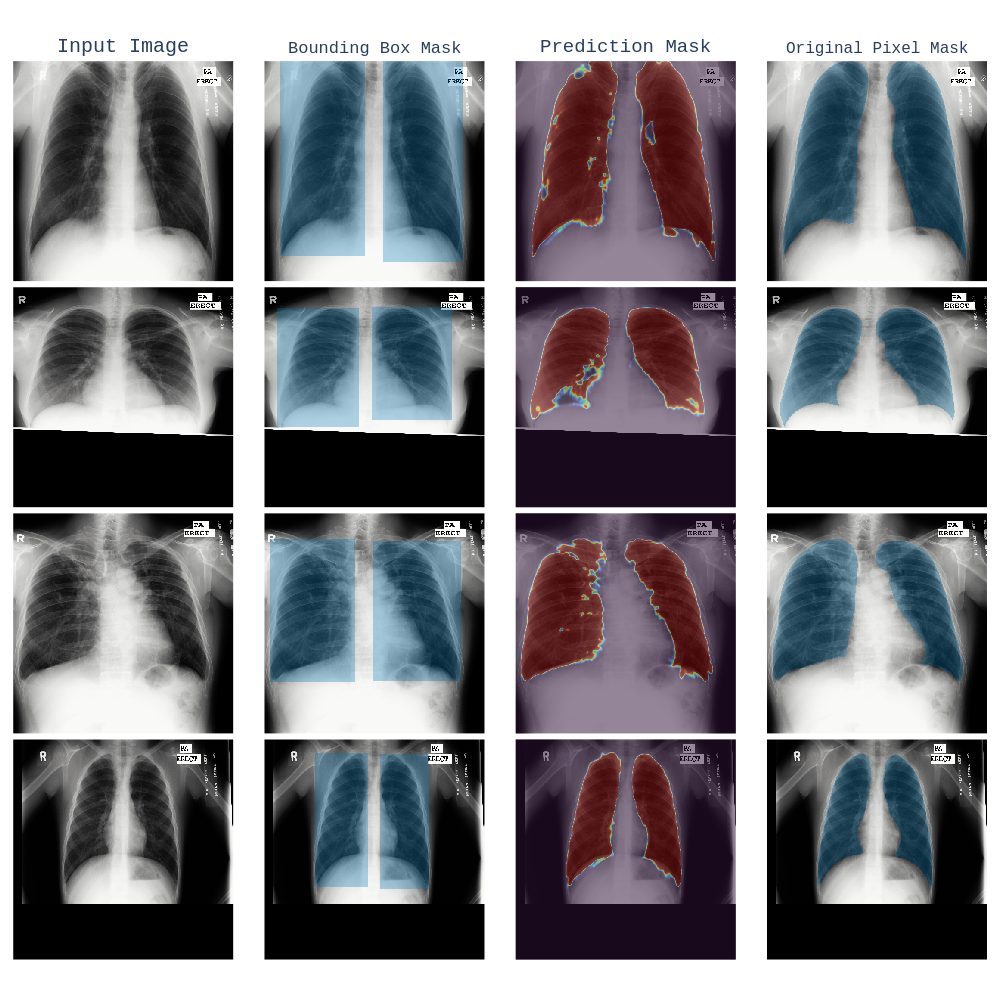

In [12]:
sample_num = 4

GridDisplay([BatchDisplay(image=image[0:sample_num], title="Input Image"), 
            BatchDisplay(image=image[0:sample_num], masks=bbox_mask[0:sample_num], title="Bounding Box Mask"),
            BatchDisplay(image=image[0:sample_num], masks=prediction[0:sample_num], title="Prediction Mask"),
            BatchDisplay(image=image[0:sample_num], masks=mask[0:sample_num], title="Original Pixel Mask"),]).show()

It can be seen that we can use bounding box annotations to accurately perform semantic segmentation even without pixel-level mask annotation. This method can help us reduce annotation cost and time massively.